In [1]:
# Suppress warnings
import warnings 
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np
import calculations as clc
import aerosol_plots as aerplt
import matplotlib.pyplot as plt

In [2]:
def generate_aerosols():
    # aerosol type (citation)
    # prop = [name, mean radius (um), hygroscopicity=kappa]

    mu = 0.1
    aerosol_list = list()
    for kappa in np.linspace(0,1.5,9):
        aer = ['', mu, kappa]
        aerosol_list.append(aer)

    # ammonium sulfate aerosol (Chen et al., 2018)
    sulf = ['sulfate', mu, 0.61]
    # sea salt aerosol (Zieger et al., 2017)
    seasalt = ['sea-salt', mu, 1.1]
    # mineral dust (Johnson & Osborne, 2011), (Koehler et al., 2009)
    mindust = ['mineral-dust', mu, 0.045]
    # black carbon (Wu et al., 2017), (Liu et al., 2013)
    blkcarb = ['black-carbon', mu, 0.09]
    # fresh biomass burning (Yi, 2018)
    freshburn = ['fresh-biomass-burning', mu, 0.21]
    # aged biomass burning (Malm et al., 2005), (Kreidenweis & Asa-Awuku, 2014) [(Yi, 2018) = 0.29]
    ageburn = ['aged-biomass-burning', mu, 0.04]

    aerosol_list = list([sulf, seasalt, mindust, blkcarb, freshburn, ageburn])
    
    #aerosol_list = list([sulf, ageburn])

    return(aerosol_list)

In [3]:
def calc_eps(r,N):
    # find full-max
    maxN = np.max(N)
    maxi = np.where(N == maxN)
    maxR = r[maxi]
    
    # find half-max
    x = np.abs(N - maxN/2)
    hmi = np.concatenate((np.where(x == sorted(x)[0]), np.where(x == sorted(x)[1]))).flatten()
    hmR = r[hmi]
    
    # calculate mean, fwhm (sig), and eps = sig/mu
    mu = float(maxR)
    fwhm = np.abs(hmR[1]-hmR[0])
    eps = fwhm/mu
    
    return(eps)

In [4]:
def run_one_parcel(aerosol, h, ratio):
    # environmental variables
    P0 = 1e5  # Initial Pressure, Pa
    T0 = 280.   # Initial Temperature, K
    S0 = -0.15  # Initial Supersaturation, 1-RH (85% here)

    # regime-determining variables
    w = 6.0  # updraft velocity (m/s)
    N = w*ratio # total particle number

    # initial lognormal distribution variables
    # shared variables
    sig = 1.5  # geometric standard deviation
    bins = 200 # number of bins to track (maybe choose this in relation to sigma)

    # initialize aerosol
    [name,mu,kappa] = aerosol
    initial_aerosol = pm.AerosolSpecies(name, pm.Lognorm(mu=mu, sigma=sig, N=N), kappa=kappa, bins=bins)

    dt = 1.0  # timestep (s)
    h_end = h  # end altitude (m)
    t_end = h_end/w  # end time (s)

    model = pm.ParcelModel([initial_aerosol], w, T0, S0, P0, console=False, accom=0.5)
    parcel_trace, aerosol_trace = model.run(t_end, dt, solver='cvode')

    return(initial_aerosol, parcel_trace, aerosol_trace)

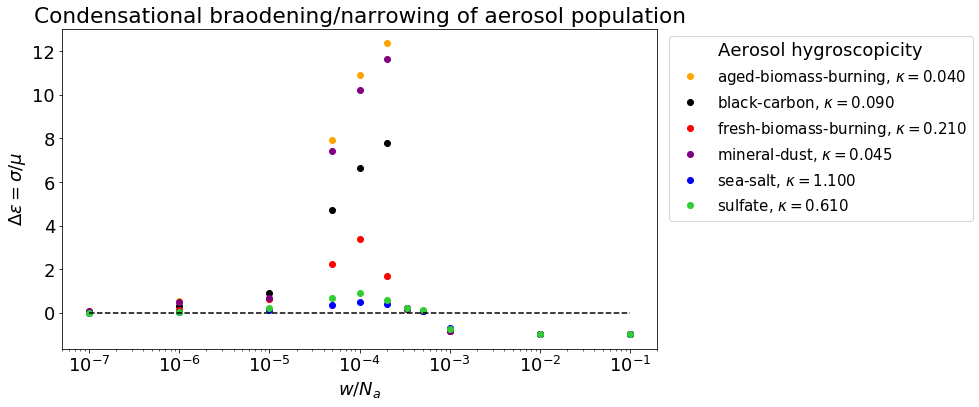

In [7]:
# set parcel conditions
ratios = [1e1,1e2,1e3,2e3,3e3,5e3,1e4,2e4,1e5,1e6,1e7]
#ratios = [1e1,1e2,1e3,1e4,1e5,1e6,1e7]
#ratios = [1e1,1e4,1e7]
h = 1e3
aerosol_list = generate_aerosols()

# make colors
names = np.array(aerosol_list)[:,0]
names, aerosol_list = zip(*sorted(zip(names, aerosol_list), key=lambda t: t[0]))

cols = ['orange','black','red','purple','blue','limegreen','pink','teal','gold']
cols = dict(zip(names, cols[0:len(names)]))

# # create lists
# initial_aerosols = list()
# parcel_traces = list()
# aerosol_traces = list()
# delta_eps = list()
# regime = list()
# kappas = list()

fig = plt.figure(figsize=(14,6))

# run parcels, fill lists
for i,ratio in enumerate(ratios):
    for j,aerosol in enumerate(aerosol_list):
        initial_aerosol, parcel_trace, aerosol_trace = run_one_parcel(aerosol, h, ratio)
#         initial_aerosols.append(initial_aerosol)
#         parcel_traces.append(parcel_trace)
#         aerosol_traces.append(aerosol_trace)
        N = initial_aerosol.Nis
        name = list(aerosol_trace.keys())[0]
        ri = aerosol_trace[name].values[0,:]
        rf = aerosol_trace[name].values[-1,:]
        epsi = calc_eps(ri,N)
        epsf = calc_eps(rf,N)
        deps = epsf-epsi
#         delta_eps.append(deps)
#         regime.append(ratio)
#         kappas.append(initial_aerosol.kappa)
        
        # plot, only label once
        label = name+", $\kappa = ${:.3f}".format(initial_aerosol.kappa)
        if i == 0:
            plt.semilogx(1/ratio, deps,'o',color=cols[name],label=label)
        else:
            plt.semilogx(1/ratio, deps,'o',color=cols[name])

# plot 0 line
plt.semilogx([1/max(ratios),1/min(ratios)], [0,0], 'k--')

# set plot properties
plt.title("Condensational braodening/narrowing of aerosol population")
plt.xlabel("$w/N_a$")
plt.ylabel(r"$\Delta \epsilon = \sigma / \mu$")
plt.rcParams.update({'font.size': 18})
plt.legend(title="Aerosol hygroscopicity", loc=(1.02,0.4), fontsize=15)
plt.tight_layout()

# save plot
savename = "./figs/regime/Deps_by_kappa_dense.png"
plt.savefig(savename,dpi=300)
plt.show()